# POMDPs and LIMIDs

In this example, we'll look at the "Pigs" problem from __[Lauritzen and Nilsson (2001)](http://web.math.ku.dk/~lauritzen/papers/limids.pdf)__, which describes a short temporal Markov decision process with latent (not directly observable) variables, as both a classic (perfect recall) influence diagram, and a limited-information influence diagram (LimID).  

The problem set-up is:

>A pig breeder is growing pigs for a period of four months and subsequently selling them.   During this period the pig may or may not develop a certain disease.  If the pig has the disease at the time it must be sold, the pig must be sold for slaughtering, and its expected market price is then 300 DKK (Danish kroner).  If it is disease free, its expected market price as a breeding animal is 1000 DKK.

>Once a month, a veterinary doctor sees the pig and makes a test for presence of the disease.  If the pig is ill, the test will indicate this with probability 0.80, and if the pig is healthy, the test will indicate this with probability 0.90.  At each monthly visit, the doctor may or may not treat the pig for the disease by injecting a certain drug.  The cost of an injection is 100 DKK.

>A pig has the disease in the first month with probability 0.10. A healthy pig develops the disease in the subsequent month with probability 0.20 without injection, whereas a healthy and treated pig develops the disease with probability 0.10, so the injection has some preventative effect.  An untreated pig that is unhealthy will remain so in the subsequent month with probability 0.90, whereas the similar probability is 0.50 for an unhealthy pig that is treated.  Thus spontaneous cure is possible, but treatment is beneficial on average.

In [1]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
%matplotlib inline                

We start by defining the chance and decision variables of the model:

In [2]:
H1,H2,H3,H4 = (gm.Var(i,2) for i in [0,1,2,3])  # latent, "healthy at month t" variables
T1,T2,T3 = (gm.Var(i,2) for i in [4,5,6])       # test results at month t
D1,D2,D3 = (gm.Var(i,2) for i in [7,8,9])       # decision to treat at month t

pH1 = gm.Factor([H1], [.1,.9])      # pig starts with disease with prob 0.10
pH12= gm.Factor([H1,H2,D1], 0.)
pH12[0,:,0] = [.9,.1]               # unhealthy & untreated, stays unhealthy with prob 0.9
pH12[1,:,0] = [.2,.8]               # healhty & untreated, stays healthy with prob 0.8
pH12[0,:,1] = [.5,.5]               # unhealthy & treated, cured with prob 0.5
pH12[1,:,1] = [.1,.9]               # healthy & treated, stays healthy with prob 0.9

pH23 = gm.Factor([H2,H3,D2], pH12.table)  # same probabilities for months 2-3
pH34 = gm.Factor([H3,H4,D3], pH12.table)  # and months 3-4

pT1 = gm.Factor([H1,T1],0.)         # test health at month t
pT1[0,:] = [.8,.2]                  # matches true health with prob .8 or .9
pT1[1,:] = [.1,.9]

pT2 = gm.Factor([H2,T2], pT1.table) # same for months 2 & 3
pT3 = gm.Factor([H3,T3], pT1.table)

U1 = gm.Factor([D1], [0, -100])     # injecting costs 100 DKK
U2 = gm.Factor([D2], [0, -100])     # injecting costs 100 DKK
U3 = gm.Factor([D3], [0, -100])     # injecting costs 100 DKK
U4 = gm.Factor([H4], [300,1000])    # healthy pigs are worth more in month 4

CFactors = [pH1,pH12,pH23,pH34,pT1,pT2,pT3]         # chance factors (CPTs)
DList = [[T1,D1],[T1,T2,D1,D2],[T1,T2,T3,D1,D2,D3]] # decisions: D1 depends on T1 & past history
UFactors = [U1,U2,U3,U4]                            # utility functions

The influence diagram picture of this problem contains random or "chance" variables (drawn as circles), the decisions or actions we can take (squares), and the utilities that influence our decisions (diamonds).  As with a Bayesian network, the parents of chance variable nodes dictate their conditional probability distribution; the parents of utility nodes indicate what influences the utility, and the edges incoming to a decision node (sometimes called informational arcs) tell us on what we can base that decision.

We can draw the influence diagram for the Pigs problem:

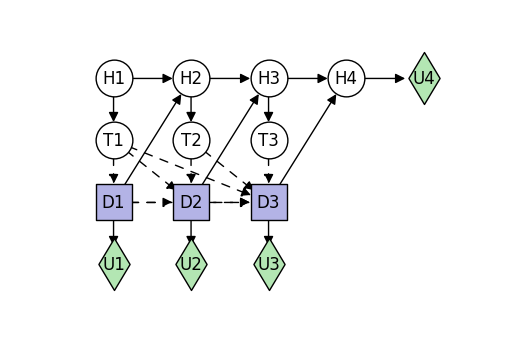

In [3]:
pos = {H1:(0,3),H2:(1,3),H3:(2,3),H4:(3,3), T1:(0,2),T2:(1,2),T3:(2,2), D1:(0,1),D2:(1,1),D3:(2,1), 
      -1:(0,0),-2:(1,0),-3:(2,0),-4:(4,3),}

labels = {H1:'H1',H2:'H2',H3:'H3',H4:'H4', T1:'T1',T2:'T2',T3:'T3', D1:'D1',D2:'D2',D3:'D3', 
          -1:'U1',-2:'U2',-3:'U3',-4:'U4'}
    
gm.drawLimid(None, CFactors,DList,UFactors, pos=pos, labels=labels, arrowsize=20, node_size=700);
ax=plt.gca(); ax.set_axis_off();

### Valuation Algebra and Variable Elimination

Rather than deal separately with probabilities and utilties, it is useful to frame our problem in terms of "valuations", which are pairs of probability and utility functions.  Then, computing expected utilities can be framed as a standard variable elimination procedure on a model consisting of valuations:

In [4]:
from valuation import Valuation, factor_to_valuation

valuations = [factor_to_valuation(f,'P',False) for f in CFactors] + \
             [factor_to_valuation(u,'U',False) for u in UFactors]
info_arcs = [factor_to_valuation(gm.Factor(d,1.),'P',False) for d in DList]
modelU = gm.GraphModel( valuations + info_arcs )

Now, we can frame finding the optimal policy as an interleaved max/sum elimination procedure.  First, we eliminate any variables that do not have any decisions as ancestors; these are unobservable random variables:

In [5]:
modelU.eliminate([H1,H2,H3,H4],'sum')  # cannot observe pig's true health

For decision variables, we maximize over the possible choices, selecting a policy that depends on any (connected) uneliminated variables.  This gives solving an ID exactly a nested "sum-max-sum" variable elimination form:

In [6]:
modelU.eliminate([D3],'max')    # solve for the optimal policy at time 3
modelU.eliminate([T3],'sum')    # average over test observations at time 3

modelU.eliminate([D2],'max')    # select the optimal policy at time 2
modelU.eliminate([T2],'sum')    # and average over test observations at time 2

By this time we have only one decision remaining (the first injection decision), and our policy depends only on the first test outcome.  We can look at the expected utilities associated with each possible policy:

In [7]:
flist = modelU.factorsWith(D1)
F = flist[0].copy()
for f in flist[1:]: F*=f;
policy = F.util.table.argmax( F.util.vars.index(D1) )
for t1 in [0,1]:
    print("T1={} => D1 = {}  ({})".format(t1,policy[t1],F.util.condition({T1:t1}).table))

T1=0 => D1 = 0  ([114.7302 106.2531])
T1=1 => D1 = 0  ([614.4948 550.6209])


This indicates that, if the pig tests unhealthy in month 1, it is optimal not to inject, and it will have an expected value of 114.7 DKK; if the pig tests healthy, it is still optimal not to inject, with an expected value of 614.5 DKK.

Completing the elimination process, we arrive at the expected value of a pig given the optimal injection policy:

In [8]:
modelU.eliminate([D1],'max')
modelU.eliminate([T1],'sum')
print(modelU.joint().util.table)

[729.225]


## LIMID version

The limited-memory version of the pig problem supposes that, due to a lack of records on each individual pig, we do not know the past test results at the time of each decision (only the current test results).  This means that our decisions may be sub-optimal (compared to the best decision given the complete observation history), but also simplifies their form (the policy can no longer depend on older tests, and is thus a simpler function):

In [9]:
CFactors = [pH1,pH12,pH23,pH34,pT1,pT2,pT3]         # chance factors (CPTs)
DList = [[T1,D1],[T2,D2],[T3,D3]]                   # decisions: now Dt depends only on Tt
UFactors = [U1,U2,U3,U4]                            # utility functions

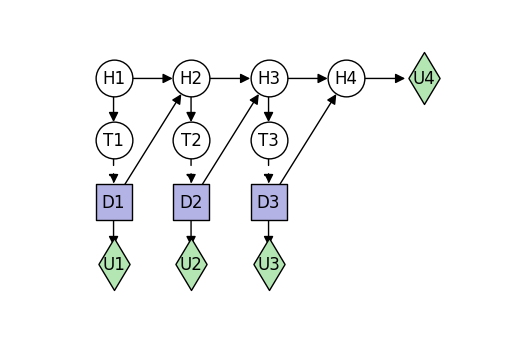

In [10]:
pos = {H1:(0,3),H2:(1,3),H3:(2,3),H4:(3,3), T1:(0,2),T2:(1,2),T3:(2,2), D1:(0,1),D2:(1,1),D3:(2,1), 
      -1:(0,0),-2:(1,0),-3:(2,0),-4:(4,3),}

labels = {H1:'H1',H2:'H2',H3:'H3',H4:'H4', T1:'T1',T2:'T2',T3:'T3', D1:'D1',D2:'D2',D3:'D3', 
          -1:'U1',-2:'U2',-3:'U3',-4:'U4'}
    
gm.drawLimid(None, CFactors,DList,UFactors, pos=pos, labels=labels, arrowsize=20, node_size=700);
ax=plt.gca(); ax.set_axis_off();

Some limited-information strategies suggested in the original paper are: uniform (treat at random), never, always, or direct (if that month's test result is positive):

In [11]:
pD1_uniform = gm.Factor([T1,D1],[[.5,.5],[.5,.5]])  # randomly give medicine
pD1_never = gm.Factor([T1,D1],[[1,0],[1,0]])        # never give medicine
pD1_always = gm.Factor([T1,D1],[[0,1],[0,1]])       # always give medicine
pD1_direct = gm.Factor([T1,D1],[[0,1],[1,0]])       # give medicine if test unhealthy

If the policies of the decision nodes are fixed, they can be viewed as random variables, and we can compute the expected value of the policy by simple marginalization.  Notably, this can follow a simpler elimination order than the perfect-recall ID, since now (for example) H3 is a sufficient statistic for the decision D3.

We can compute the expected values of the various fixed policies:

In [12]:
pD1 = pD1_direct                         # build the policy
pD2 = gm.Factor([T2,D2],pD1.table)
pD3 = gm.Factor([T3,D3],pD1.table)

valuations = [factor_to_valuation(f,'P',False) for f in CFactors] + \
             [factor_to_valuation(u,'U',False) for u in UFactors]
info_arcs = [factor_to_valuation(d,'P',False) for d in [pD1,pD2,pD3]]
modelU = gm.GraphModel( valuations + info_arcs )

modelU.eliminate([H4,D3,T3,H3,D2,T2,H2,D1,T1,H1],'sum')
print(modelU.joint().util.table)

[718.16667]


In [13]:
pD1 = pD1_never                         # build the policy
pD2 = gm.Factor([T2,D2],pD1.table)
pD3 = gm.Factor([T3,D3],pD1.table)
info_arcs = [factor_to_valuation(d,'P',False) for d in [pD1,pD2,pD3]]

modelU = gm.GraphModel( valuations + info_arcs )
modelU.eliminate([H4,D3,T3,H3,D2,T2,H2,D1,T1,H1],'sum')
print(modelU.joint().util.table)

[669.39]


In [14]:
pD1 = pD1_uniform                         # build the policy
pD2 = gm.Factor([T2,D2],pD1.table)
pD3 = gm.Factor([T3,D3],pD1.table)
info_arcs = [factor_to_valuation(d,'P',False) for d in [pD1,pD2,pD3]]

modelU = gm.GraphModel( valuations + info_arcs )
modelU.eliminate([H4,D3,T3,H3,D2,T2,H2,D1,T1,H1],'sum')
print(modelU.joint().util.table)

[643.84125]


In [15]:
pD1 = pD1_always                         # build the policy
pD2 = gm.Factor([T2,D2],pD1.table)
pD3 = gm.Factor([T3,D3],pD1.table)
policies = [factor_to_valuation(d,'P',False) for d in [pD1,pD2,pD3]]

modelU = gm.GraphModel( valuations + policies )
modelU.eliminate([H4,D3,T3,H3,D2,T2,H2,D1,T1,H1],'sum')
print(modelU.joint().util.table)

[586.32]


These computations match the values reported in the original work.

### Optimizing the LIMID policies using SPU

For a LIMID, it is not easy to find the optimal policy in closed form, as it is no longer equivalent to a simple variable elimination framing.  A simple approach proposed in Lauritzen & Nilsson (2001) is "Single Policy Updating" (SPU), which iteratively updates each decision's policy to be optimal, given the current policies of the other decisions.  In SPU, at each step, only a single decision exists (the others are all viewed as chance nodes), and we can solve for that decision's policy using elimination.

In [47]:
CFactors = [pH1,pH12,pH23,pH34,pT1,pT2,pT3]         # chance factors (CPTs)
DList = [[T1,D1],[T2,D2],[T3,D3]]                   # decisions: now Dt depends only on Tt
UFactors = [U1,U2,U3,U4]                            # utility functions

pD1 = pD1_uniform                                   # initialize the policy
pD2 = gm.Factor([T2,D2],pD1.table)
pD3 = gm.Factor([T3,D3],pD1.table)

valuations = [factor_to_valuation(f,'P',False) for f in CFactors] + \
             [factor_to_valuation(u,'U',False) for u in UFactors]
policies = [factor_to_valuation(d,'P',False) for d in [pD1,pD2,pD3]]
modelU = gm.GraphModel( valuations + policies )

# Find elimination orders that leave each decision until last:
orders = [gm.eliminationOrder(modelU,'wtminfill',priority=[1 if x in p.vars else 0 for x in modelU.X])[0] for p in [pD1,pD2,pD3]]

for it in range(5):
    for i in range(3):
        model = gm.GraphModel( valuations + policies[:i]+policies[i+1:] )  # Model with all policies but i's
        Di = DList[i][-1]
        model.eliminate(orders[i][:-policies[i].nvar],'sum')               # Eliminate all but policy i's vars
        EU = model.joint()
        
        delta_i = (EU.util/EU.util.max([Di]))**(1000)       # make delta_i a (nearly) deterministic policy
        delta_i = delta_i / delta_i.sum([Di])
        policies[i] = factor_to_valuation(delta_i,'P',False)
        
        print("SPU It {}.{}: EU = {}".format(it,i,(delta_i*EU.util).sum()))

SPU It 0.0: EU = 680.0775
SPU It 0.1: EU = 702.4095
SPU It 0.2: EU = 726.812098281
SPU It 1.0: EU = 726.812098281
SPU It 1.1: EU = 726.812098242
SPU It 1.2: EU = 726.812098242
SPU It 2.0: EU = 726.812098242
SPU It 2.1: EU = 726.812098242
SPU It 2.2: EU = 726.812098242
SPU It 3.0: EU = 726.812098242
SPU It 3.1: EU = 726.812098242
SPU It 3.2: EU = 726.812098242
SPU It 4.0: EU = 726.812098242
SPU It 4.1: EU = 726.812098242
SPU It 4.2: EU = 726.812098242


This procedure will fairily quickly converge on a locally optimal set of policies.  We can see that, in this example, we get pretty close to the optimal utility (729 DKK) even with the limited information (current test results only) on which to base our decisions.